# Time Series Forecasting con Transformers de Hugging Face
# Dataset: Precio de Bitcoin en USD (BTC-USD)

In [1]:
!pip install darts --quiet
!pip install neuralforecast --quiet

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import zipfile
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.metrics import mae, rmse, mape
from darts.models import TransformerModel, NHiTSModel, TFTModel
import random
import torch
import time

# Importaciones para Informer
from neuralforecast import NeuralForecast
from neuralforecast.models import Informer
from neuralforecast.losses.pytorch import MAE

/home/jorge/miniconda3/envs/darts-env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-06-18 17:28:14,265	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-06-18 17:28:14,325	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [3]:
# Descargar y descomprimir el dataset desde Kaggle usando curl directo
zip_path = "bitcoin-historical-data.zip"
csv_filename = "btcusd_1-min_data.csv"

if not os.path.exists(csv_filename):
    if not os.path.exists(zip_path):
        !curl -L -o bitcoin-historical-data.zip \
            https://www.kaggle.com/api/v1/datasets/download/mczielinski/bitcoin-historical-data
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(".")

In [4]:
# Funciones auxiliares
def count_model_parameters(darts_model):
    """Cuenta los parámetros entrenables de un modelo Darts basado en PyTorch."""
    try:
        # La mayoría de los modelos Darts basados en PyTorch exponen el modelo subyacente en '.model'
        if hasattr(darts_model, 'model') and hasattr(darts_model.model, 'parameters'):
             return sum(p.numel() for p in darts_model.model.parameters() if p.requires_grad)
        elif hasattr(darts_model, '_model') and hasattr(darts_model._model, 'parameters'):
             return sum(p.numel() for p in darts_model._model.parameters() if p.requires_grad)
        else:
            print(f"Advertencia: No se pudo acceder a los parámetros para {type(darts_model)}. Verifique la estructura interna del modelo. Se devolverá 0.")
            return 0
    except Exception as e:
        print(f"Error al contar parámetros para {type(darts_model)}: {e}. Se devolverá 0.")
        return 0

def count_informer_parameters(nf_model):
    """Cuenta los parámetros entrenables de un modelo NeuralForecast Informer."""
    try:
        # Acceder al modelo PyTorch interno del Informer
        if hasattr(nf_model, 'models') and len(nf_model.models) > 0:
            informer_model = nf_model.models[0]
            if hasattr(informer_model, 'model') and hasattr(informer_model.model, 'parameters'):
                return sum(p.numel() for p in informer_model.model.parameters() if p.requires_grad)
        print(f"Advertencia: No se pudo acceder a los parámetros del modelo Informer. Se devolverá 0.")
        return 0
    except Exception as e:
        print(f"Error al contar parámetros del modelo Informer: {e}. Se devolverá 0.")
        return 0

# Cálculo de métricas
def calc_metrics(pred):
    return {
        'MAE': mae(test, pred),
        'MAPE': mape(test, pred),
        'RMSE': rmse(test, pred)
    }

# Función para crear y mostrar un gráfico de barras agrupadas para una métrica
def plot_custom_barchart(df, value_columns, value_short_names, title, y_label, lower_is_better=True, value_format=".4f"):
    """
    Crea un gráfico de barras agrupadas para un conjunto personalizado de columnas.

    Args:
        df (pd.DataFrame): DataFrame con los resultados.
        value_columns (list): Lista de nombres de columnas del df que contienen los valores a graficar.
        value_short_names (list): Lista de nombres cortos para la leyenda (debe coincidir con value_columns).
        title (str): Título del gráfico.
        y_label (str): Etiqueta para el eje Y.
        lower_is_better (bool): True si valores más bajos son mejores (para métricas de error).
                                False si valores más altos son mejores (ej. para precisión).
        value_format (str): Formato para las anotaciones numéricas en las barras.
    """
    if len(value_columns) != len(value_short_names):
        raise ValueError("value_columns y value_short_names deben tener la misma longitud.")

    # Crear un DataFrame temporal para el gráfico
    plot_df = df[['Ventana'] + value_columns].copy()
    plot_df.columns = ['Ventana'] + value_short_names

    plot_df.set_index('Ventana', inplace=True)

    # Determinar el colormap basado en si menor es mejor o no
    cmap_choice = 'viridis_r' if lower_is_better else 'viridis'

    ax = plot_df.plot(kind='bar', figsize=(12, 7), colormap=cmap_choice)

    plt.title(title, fontsize=16, pad=20)
    plt.ylabel(y_label, fontsize=12)
    plt.xlabel('Configuración de Ventana de Entrenamiento', fontsize=12)
    plt.xticks(rotation=0)
    plt.legend(title='Modelo')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Añadir etiquetas de valor encima de las barras
    for p in ax.patches:
        ax.annotate(format(p.get_height(), value_format),
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center',
                    xytext=(0, 9),
                    textcoords='offset points',
                    fontsize=8)

    plt.tight_layout()
    plt.show()

Seed set to 1
/home/jorge/miniconda3/envs/darts-env/lib/python3.11/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti SUPER') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion  


Entrenando con ventana de 1_año (365 días)

Entrenando modelos con ventana 1_año...
Epoch 99: 100%|██████████| 10/10 [00:00<00:00, 62.71it/s, train_loss=0.000835]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 10/10 [00:00<00:00, 62.35it/s, train_loss=0.000835]
Transformer entrenado en: 16.83s, Parámetros: 549,386


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 248 K  | train
-------------------------------------------------------------
240 K     Trainable params
7.7 K     Non-trainable params
248 K     Total params
0.994     Total estimated model params size (MB)
84        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 10/10 [00:00<00:00, 124.66it/s, train_loss=0.000529]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 10/10 [00:00<00:00, 123.51it/s, train_loss=0.000529]
NHiTS entrenado en: 7.44s, Parámetros: 240,818


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 3.5 K  | train
5  | decoder_vsn                       | _VariableSelectionNetwork        | 1.6 K  | train
6  | static_context_grn                | _GatedResidualNetwork            | 16.8 K | train
7  | static_cont

Epoch 99: 100%|██████████| 10/10 [00:00<00:00, 41.90it/s, train_loss=0.0912]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 10/10 [00:00<00:00, 41.78it/s, train_loss=0.0912]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


TFT entrenado en: 24.17s, Parámetros: 279,727
Entrenando Informer...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MAE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | enc_embedding | DataEmbedding | 96     | train
4 | dec_embedding | DataEmbedding | 96     | train
5 | encoder       | TransEncoder  | 20.3 K | train
6 | decoder       | TransDecoder  | 12.9 K | train
--------------------------------------------------------
33.4 K    Trainable params
0         Non-trainable params
33.4 K    Total params
0.134     Total estimated model params size (MB)
73        Modules in train mode
0         Modules in eval mode


Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 30.76it/s, v_num=0, train_loss_step=1.250, train_loss_epoch=1.250, valid_loss=2.51e+3]

`Trainer.fit` stopped: `max_steps=500` reached.


Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 29.73it/s, v_num=0, train_loss_step=1.250, train_loss_epoch=1.250, valid_loss=2.51e+3]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Advertencia: No se pudo acceder a los parámetros del modelo Informer. Se devolverá 0.
Informer entrenado en: 10.65s, Parámetros: 0
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 168.76it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 259.12it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.27it/s]


Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.82it/s]


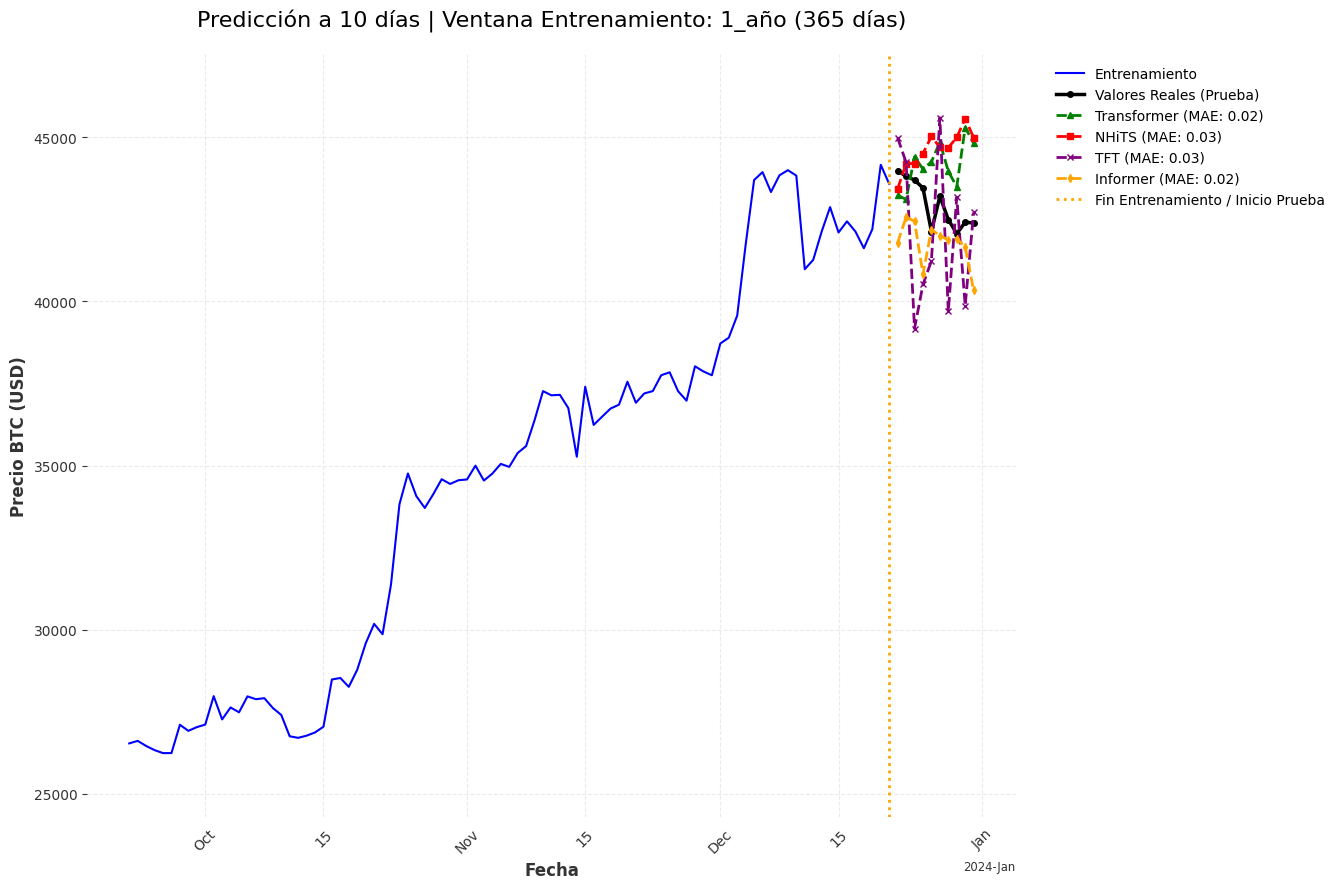


Entrenando con ventana de 6_meses (180 días)


Seed set to 1
/home/jorge/miniconda3/envs/darts-env/lib/python3.11/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positi


Entrenando modelos con ventana 6_meses...
Epoch 99: 100%|██████████| 4/4 [00:00<00:00, 61.65it/s, train_loss=0.00228]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 4/4 [00:00<00:00, 60.97it/s, train_loss=0.00228]
Transformer entrenado en: 6.8s, Parámetros: 549,386


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 248 K  | train
-------------------------------------------------------------
240 K     Trainable params
7.7 K     Non-trainable params
248 K     Total params
0.994     Total estimated model params size (MB)
84        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 4/4 [00:00<00:00, 125.65it/s, train_loss=0.000885]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 4/4 [00:00<00:00, 122.92it/s, train_loss=0.000885]
NHiTS entrenado en: 3.25s, Parámetros: 240,818


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 3.5 K  | train
5  | decoder_vsn                       | _VariableSelectionNetwork        | 1.6 K  | train
6  | static_context_grn                | _GatedResidualNetwork            | 16.8 K | train
7  | static_cont

Epoch 99: 100%|██████████| 4/4 [00:00<00:00, 39.11it/s, train_loss=0.0988]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 4/4 [00:00<00:00, 38.84it/s, train_loss=0.0988]
TFT entrenado en: 9.94s, Parámetros: 279,727
Entrenando Informer...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MAE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | enc_embedding | DataEmbedding | 96     | train
4 | dec_embedding | DataEmbedding | 96     | train
5 | encoder       | TransEncoder  | 20.3 K | train
6 | decoder       | TransDecoder  | 12.9 K | train
--------------------------------------------------------
33.4 K    Trainable params
0         Non-trainable params
33.4 K    Total params
0.134     Total estimated model params size (MB)
73        Modules in train mode
0         Modules in eval mode


Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 26.67it/s, v_num=2, train_loss_step=1.360, train_loss_epoch=1.360, valid_loss=1.01e+3]

`Trainer.fit` stopped: `max_steps=500` reached.


Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 25.97it/s, v_num=2, train_loss_step=1.360, train_loss_epoch=1.360, valid_loss=1.01e+3]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Advertencia: No se pudo acceder a los parámetros del modelo Informer. Se devolverá 0.
Informer entrenado en: 11.01s, Parámetros: 0
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 161.86it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.53it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 113.41it/s]

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 110.09it/s]


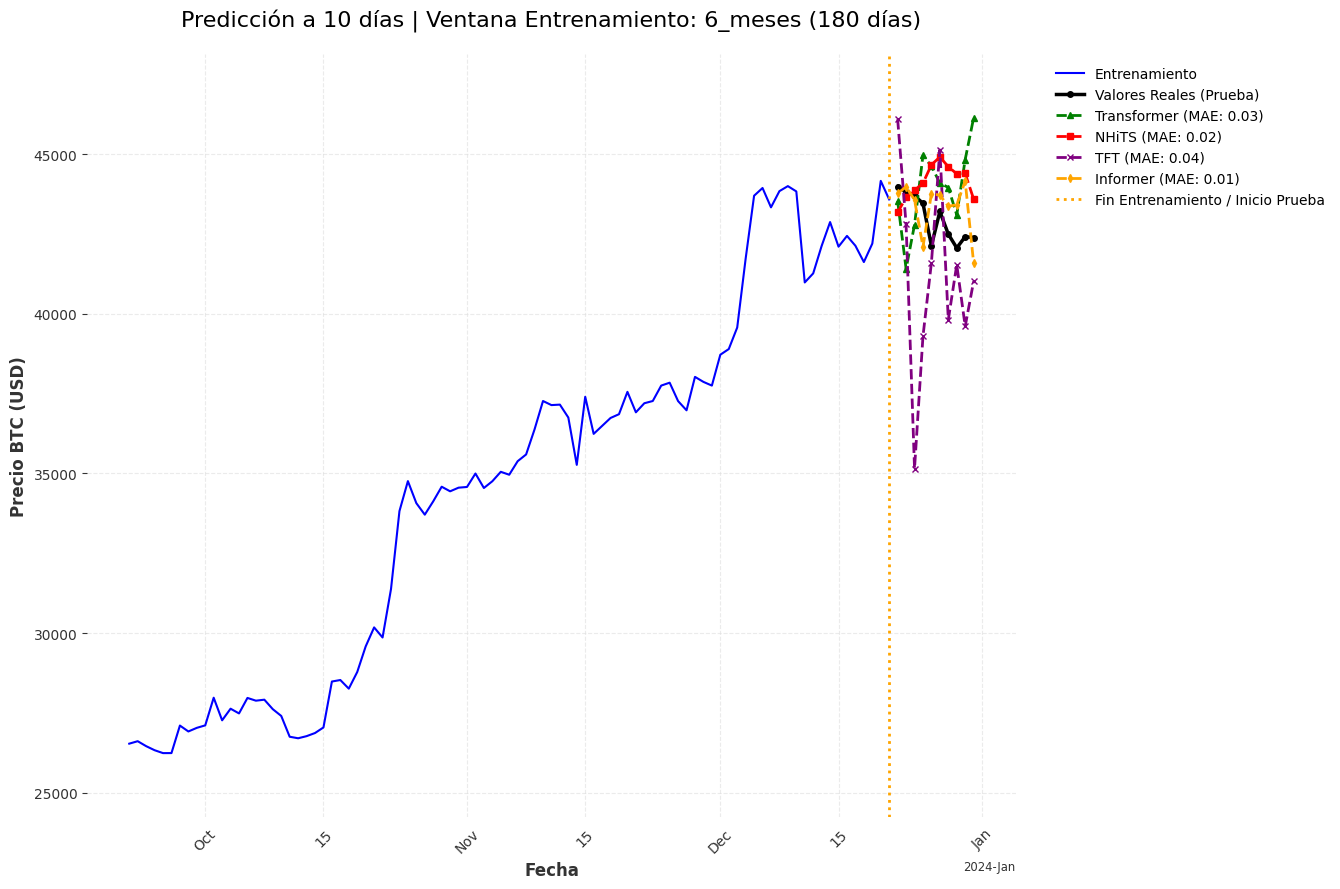

Seed set to 1



Entrenando con ventana de 3_meses (90 días)

Entrenando modelos con ventana 3_meses...


/home/jorge/miniconda3/envs/darts-env/lib/python3.11/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding 

Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 59.01it/s, train_loss=0.00607]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 57.70it/s, train_loss=0.00607]
Transformer entrenado en: 3.45s, Parámetros: 549,386


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 227 K  | train
-------------------------------------------------------------
223 K     Trainable params
3.9 K     Non-trainable params
227 K     Total params
0.909     Total estimated model params size (MB)
84        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 110.32it/s, train_loss=0.000855]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 106.21it/s, train_loss=0.000855]
NHiTS entrenado en: 1.86s, Parámetros: 223,338


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 3.5 K  | train
5  | decoder_vsn                       | _VariableSelectionNetwork        | 1.6 K  | train
6  | static_context_grn                | _GatedResidualNetwork            | 16.8 K | train
7  | static_cont

Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 55.10it/s, train_loss=0.171]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 54.05it/s, train_loss=0.171]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MAE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | enc_embedding | DataEmbedding | 96     | train
4 | dec_embedding | DataEmbedding | 96     | train
5 | encoder       | TransEncoder  | 20.3 K | train
6 | decoder       | TransDecoder  | 12.9 K | train
--------------------------------------------------------
33.4 K    Trainable params
0         Non-trainable params
33.4 K    Total params
0.134     Total estimated model params size (MB)
73        Modules in train mode
0         Modules in eval mode


TFT entrenado en: 3.99s, Parámetros: 279,727
Entrenando Informer...
Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 28.97it/s, v_num=4, train_loss_step=1.480, train_loss_epoch=1.480, valid_loss=810.0]  

`Trainer.fit` stopped: `max_steps=500` reached.


Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 28.06it/s, v_num=4, train_loss_step=1.480, train_loss_epoch=1.480, valid_loss=810.0]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Advertencia: No se pudo acceder a los parámetros del modelo Informer. Se devolverá 0.
Informer entrenado en: 9.89s, Parámetros: 0
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 163.61it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 259.92it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 128.78it/s]


Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.21it/s]


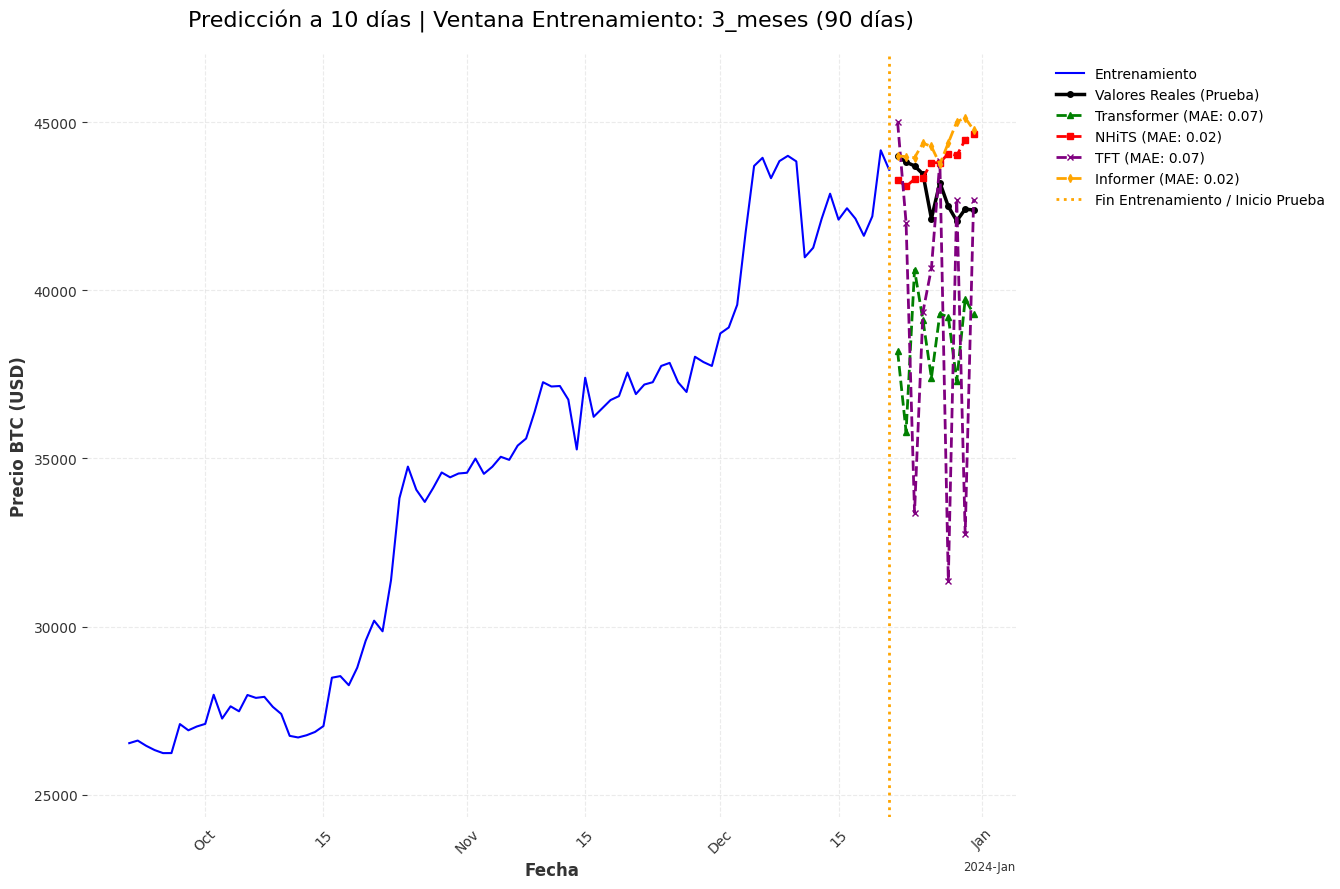


Resultados Comparativos:
| Ventana   |   Días |   Transformer_MAE |   Transformer_MAPE |   Transformer_RMSE |   Transformer_TrainTime_s |   Transformer_Params |   NHiTS_MAE |   NHiTS_MAPE |   NHiTS_RMSE |   NHiTS_TrainTime_s |   NHiTS_Params |   TFT_MAE |   TFT_MAPE |   TFT_RMSE |   TFT_TrainTime_s |   TFT_Params |   Informer_MAE |   Informer_MAPE |   Informer_RMSE |   Informer_TrainTime_s |   Informer_Params |
|:----------|-------:|------------------:|-------------------:|-------------------:|--------------------------:|---------------------:|------------:|-------------:|-------------:|--------------------:|---------------:|----------:|-----------:|-----------:|------------------:|-------------:|---------------:|----------------:|----------------:|-----------------------:|------------------:|
| 1_año     |    365 |            0.0234 |             3.9042 |             0.0264 |                     16.83 |               549386 |      0.0283 |       4.7246 |       0.0328 |               

In [5]:
# Establecer todas las semillas para reproducibilidad
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

# Fechas fijas para el análisis
START_DATE = '2020-01-01'
END_DATE = '2023-12-31'
PREDICTION_HORIZON = 10  # 10 días hacia adelante

# Cargar y preparar datos
df = pd.read_csv("btcusd_1-min_data.csv")
df['date'] = pd.to_datetime(df['Timestamp'], unit='s')
df = df.rename(columns={'Close': 'price'})
df = df[['date', 'price']].dropna()
df = df[(df['date'] >= START_DATE) & (df['date'] <= END_DATE)]
df_daily = df.set_index('date').resample('D').last().ffill()

# Convertir a serie temporal para Darts
series = TimeSeries.from_dataframe(df_daily.reset_index(), 'date', 'price')
scaler = Scaler()
series_scaled = scaler.fit_transform(series)
series_unscaled = scaler.inverse_transform(series_scaled)

# Preparar datos para NeuralForecast - formato requerido
df_neuralforecast = df_daily.reset_index()
df_neuralforecast['unique_id'] = 'BTC'  # Identificador único requerido
df_neuralforecast = df_neuralforecast.rename(columns={'date': 'ds', 'price': 'y'})
df_neuralforecast = df_neuralforecast[['unique_id', 'ds', 'y']]

# Configuraciones de ventanas históricas a probar
WINDOW_CONFIGS = {
    '1_año': 365,
    '6_meses': 180,
    '3_meses': 90,
}

results = []

for config_name, window_size in WINDOW_CONFIGS.items():
    print(f"\n{'='*50}")
    print(f"Entrenando con ventana de {config_name} ({window_size} días)")
    print(f"{'='*50}")

    # Definir períodos de entrenamiento y prueba
    train_end = series.time_index[-PREDICTION_HORIZON-1]
    train_start = train_end - pd.Timedelta(days=window_size)
    test_start = train_end + pd.Timedelta(days=1)
    test_end = test_start + pd.Timedelta(days=PREDICTION_HORIZON-1)

    # Crear subseries para Darts
    train = series_scaled.slice(train_start, train_end)
    test = series_scaled.slice(test_start, test_end)

    # Preparar datos para NeuralForecast
    nf_train_df = df_neuralforecast[
        (df_neuralforecast['ds'] >= train_start) & 
        (df_neuralforecast['ds'] <= train_end)
    ].copy()
    
    nf_test_df = df_neuralforecast[
        (df_neuralforecast['ds'] >= test_start) & 
        (df_neuralforecast['ds'] <= test_end)
    ].copy()

    # Configuración común de modelos Darts
    common_args = {
        'input_chunk_length': min(60, window_size//3),
        'output_chunk_length': PREDICTION_HORIZON,
        'random_state': SEED,
        'n_epochs': 100,
        'batch_size': 32,
        'optimizer_kwargs': {'lr': 1e-3},
        'model_name': f'{config_name}_model'
    }

    # Inicializar modelos Darts
    transformer = TransformerModel(
        **common_args,
        d_model=64,
        nhead=4,
        num_encoder_layers=3,
        num_decoder_layers=3,
        dropout=0.1
    )

    nhits = NHiTSModel(
        **common_args,
        num_blocks=2,
        num_layers=3,
        layer_widths=128,
        dropout=0.1
    )

    tft = TFTModel(
        **common_args,
        hidden_size=64,
        lstm_layers=2,
        dropout=0.1,
        add_relative_index=True
    )

    # Configurar modelo Informer
    informer_model = Informer(
        h=PREDICTION_HORIZON,
        input_size=min(60, window_size//3),
        hidden_size=32,
        conv_hidden_size=64,
        n_head=2,
        loss=MAE(),
        scaler_type='standard',
        learning_rate=1e-5,
        max_steps=500,
        val_check_steps=25,
        early_stop_patience_steps=5,
        encoder_layers=2,
        decoder_layers=1,
        dropout=0.3,
        batch_size=8
    )

    nf = NeuralForecast(
        models=[informer_model],
        freq='D'
    )

    # Entrenamiento y medición de tiempo
    print(f"\nEntrenando modelos con ventana {config_name}...")

    # Transformer
    start_time_trans = time.time()
    transformer.fit(train, verbose=True)
    end_time_trans = time.time()
    train_time_trans = round(end_time_trans - start_time_trans, 2)
    params_trans = count_model_parameters(transformer)
    print(f"Transformer entrenado en: {train_time_trans}s, Parámetros: {params_trans:,}")

    # NHiTS
    start_time_nhits = time.time()
    nhits.fit(train, verbose=True)
    end_time_nhits = time.time()
    train_time_nhits = round(end_time_nhits - start_time_nhits, 2)
    params_nhits = count_model_parameters(nhits)
    print(f"NHiTS entrenado en: {train_time_nhits}s, Parámetros: {params_nhits:,}")

    # TFT
    start_time_tft = time.time()
    tft.fit(train, verbose=True)
    end_time_tft = time.time()
    train_time_tft = round(end_time_tft - start_time_tft, 2)
    params_tft = count_model_parameters(tft)
    print(f"TFT entrenado en: {train_time_tft}s, Parámetros: {params_tft:,}")

    # Informer
    start_time_informer = time.time()
    print("Entrenando Informer...")
    nf.fit(df=nf_train_df, val_size=min(12, len(nf_train_df)//5))
    end_time_informer = time.time()
    train_time_informer = round(end_time_informer - start_time_informer, 2)
    params_informer = count_informer_parameters(nf)
    print(f"Informer entrenado en: {train_time_informer}s, Parámetros: {params_informer:,}")

    # Predicción
    pred_trans = transformer.predict(n=PREDICTION_HORIZON)
    pred_nhits = nhits.predict(n=PREDICTION_HORIZON)
    pred_tft = tft.predict(n=PREDICTION_HORIZON)

    # Predicción Informer
    informer_forecasts = nf.predict(futr_df=nf_test_df[['unique_id', 'ds']])
    informer_values = informer_forecasts['Informer'].values
    
    # Convertir predicción de Informer a TimeSeries y escalar para comparación
    temp_informer_original = TimeSeries.from_times_and_values(
        times=test.time_index,
        values=informer_values
    )
    pred_informer_scaled = scaler.transform(temp_informer_original)

    # Cálculo de métricas
    metrics_trans = calc_metrics(pred_trans)
    metrics_nhits = calc_metrics(pred_nhits)
    metrics_tft = calc_metrics(pred_tft)
    metrics_informer = calc_metrics(pred_informer_scaled)

    # Almacenar resultados
    results.append({
        'Ventana': config_name,
        'Días': window_size,
        'Transformer_MAE': round(metrics_trans['MAE'], 4),
        'Transformer_MAPE': round(metrics_trans['MAPE'], 4),
        'Transformer_RMSE': round(metrics_trans['RMSE'], 4),
        'Transformer_TrainTime_s': train_time_trans,
        'Transformer_Params': params_trans,
        'NHiTS_MAE': round(metrics_nhits['MAE'], 4),
        'NHiTS_MAPE': round(metrics_nhits['MAPE'], 4),
        'NHiTS_RMSE': round(metrics_nhits['RMSE'], 4),
        'NHiTS_TrainTime_s': train_time_nhits,
        'NHiTS_Params': params_nhits,
        'TFT_MAE': round(metrics_tft['MAE'], 4),
        'TFT_MAPE': round(metrics_tft['MAPE'], 4),
        'TFT_RMSE': round(metrics_tft['RMSE'], 4),
        'TFT_TrainTime_s': train_time_tft,
        'TFT_Params': params_tft,
        'Informer_MAE': round(metrics_informer['MAE'], 4),
        'Informer_MAPE': round(metrics_informer['MAPE'], 4),
        'Informer_RMSE': round(metrics_informer['RMSE'], 4),
        'Informer_TrainTime_s': train_time_informer,
        'Informer_Params': params_informer,
    })

    # Preparar datos para visualización
    test_unscaled = scaler.inverse_transform(test)
    pred_trans_unscaled = scaler.inverse_transform(pred_trans)
    pred_nhits_unscaled = scaler.inverse_transform(pred_nhits)
    pred_tft_unscaled = scaler.inverse_transform(pred_tft)
    pred_informer_unscaled = temp_informer_original  # Ya está en escala original

    # Visualización
    plt.figure(figsize=(16, 9))

    # 1. Definir un contexto de días para mostrar antes de la predicción
    context_days_before_prediction = 90

    # Calcular el inicio del tramo de entrenamiento a graficar
    plot_train_start_date = train_end - pd.Timedelta(days=context_days_before_prediction)
    plot_train_start_date = max(plot_train_start_date, series_unscaled.start_time())

    # Graficar datos históricos de entrenamiento (solo el contexto definido)
    training_plot_slice = series_unscaled.slice(plot_train_start_date, train_end)
    training_plot_slice.plot(label=f'Entrenamiento', color='blue', linewidth=1.5)

    # 2. Graficar valores reales del período de prueba
    test_unscaled.plot(label='Valores Reales (Prueba)', color='black', linewidth=2.5, marker='o', markersize=4)

    # 3. Graficar predicciones
    pred_trans_unscaled.plot(
        label=f'Transformer (MAE: {metrics_trans["MAE"]:.2f})',
        color='green',
        linestyle='--',
        linewidth=2, marker='^', markersize=4)

    pred_nhits_unscaled.plot(
        label=f'NHiTS (MAE: {metrics_nhits["MAE"]:.2f})',
        color='red',
        linestyle='--',
        linewidth=2, marker='s', markersize=4)

    pred_tft_unscaled.plot(
        label=f'TFT (MAE: {metrics_tft["MAE"]:.2f})',
        color='purple',
        linestyle='--',
        linewidth=2, marker='x', markersize=4)

    pred_informer_unscaled.plot(
        label=f'Informer (MAE: {metrics_informer["MAE"]:.2f})',
        color='orange',
        linestyle='--',
        linewidth=2, marker='d', markersize=4)

    # 4. Línea vertical para marcar fin de entrenamiento / inicio de prueba
    plt.axvline(x=train_end, color='orange', linestyle=':', linewidth=2,
               label='Fin Entrenamiento / Inicio Prueba')

    # 5. Ajustar límites del eje Y para enfocarse en el área de predicción
    data_for_ylim_calc = []
    data_for_ylim_calc.extend(training_plot_slice.values().flatten())
    data_for_ylim_calc.extend(test_unscaled.values().flatten())
    data_for_ylim_calc.extend(pred_trans_unscaled.values().flatten())
    data_for_ylim_calc.extend(pred_nhits_unscaled.values().flatten())
    data_for_ylim_calc.extend(pred_tft_unscaled.values().flatten())
    data_for_ylim_calc.extend(pred_informer_unscaled.values().flatten())

    min_val = np.min(data_for_ylim_calc)
    max_val = np.max(data_for_ylim_calc)
    padding = (max_val - min_val) * 0.10

    plt.ylim(min_val - padding, max_val + padding)

    # Configuración del gráfico
    plt.title(f'Predicción a {PREDICTION_HORIZON} días | Ventana Entrenamiento: {config_name} ({window_size} días)', pad=20, fontsize=16)
    plt.xlabel('Fecha', fontsize=12)
    plt.ylabel('Precio BTC (USD)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(rotation=45)
    plt.tick_params(axis='both', which='major', labelsize=10)

    # Leyenda
    plt.legend(bbox_to_anchor=(1.03, 1), loc='upper left', fontsize=10)

    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()

# Resultados comparativos
results_df = pd.DataFrame(results)
print("\nResultados Comparativos:")
print(results_df.to_markdown(index=False))

Generando gráfico de barras para MAE...


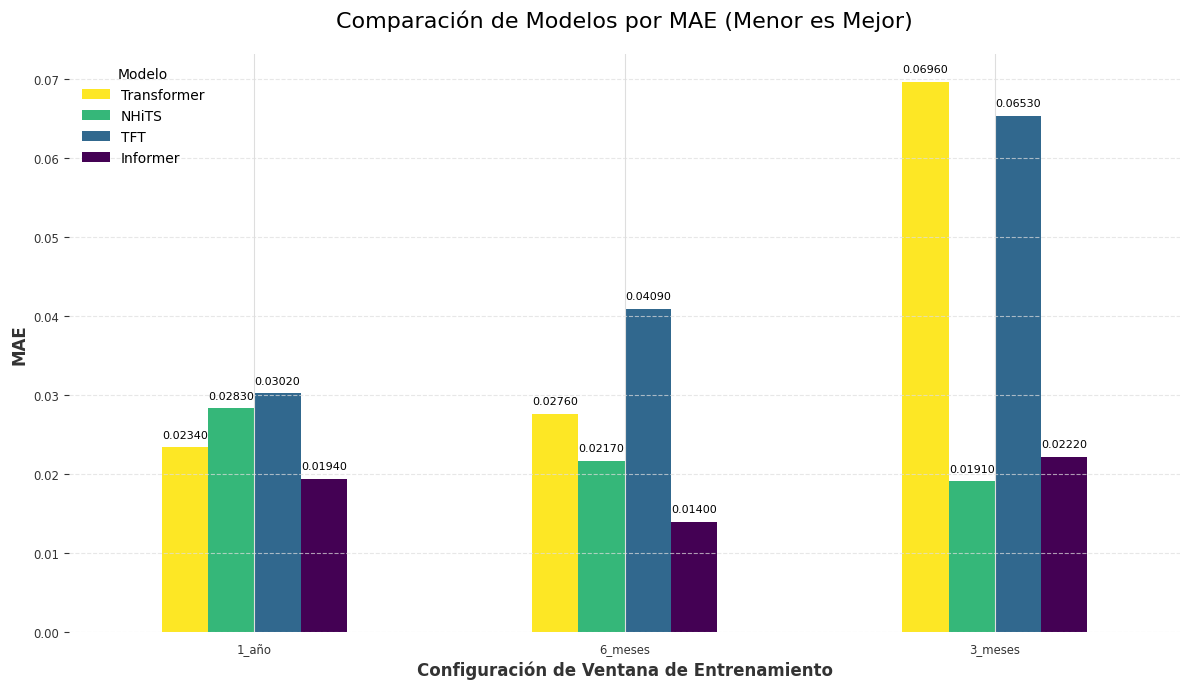

Generando gráfico de barras para MAPE...


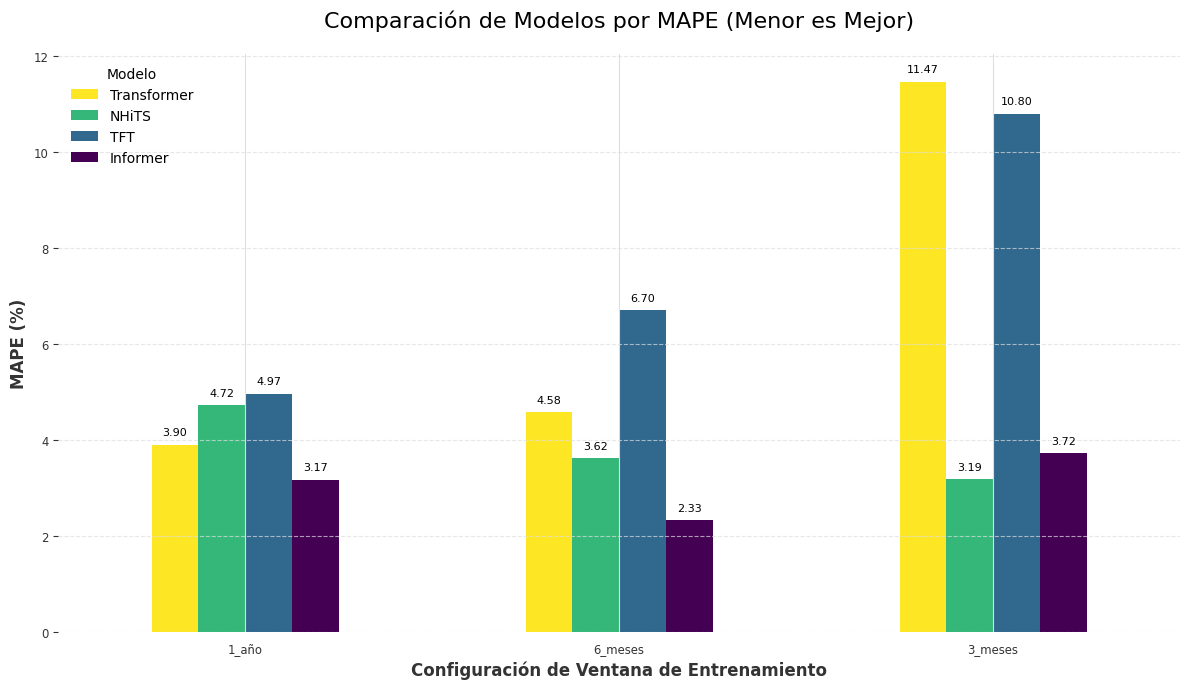

Generando gráfico de barras para RMSE...


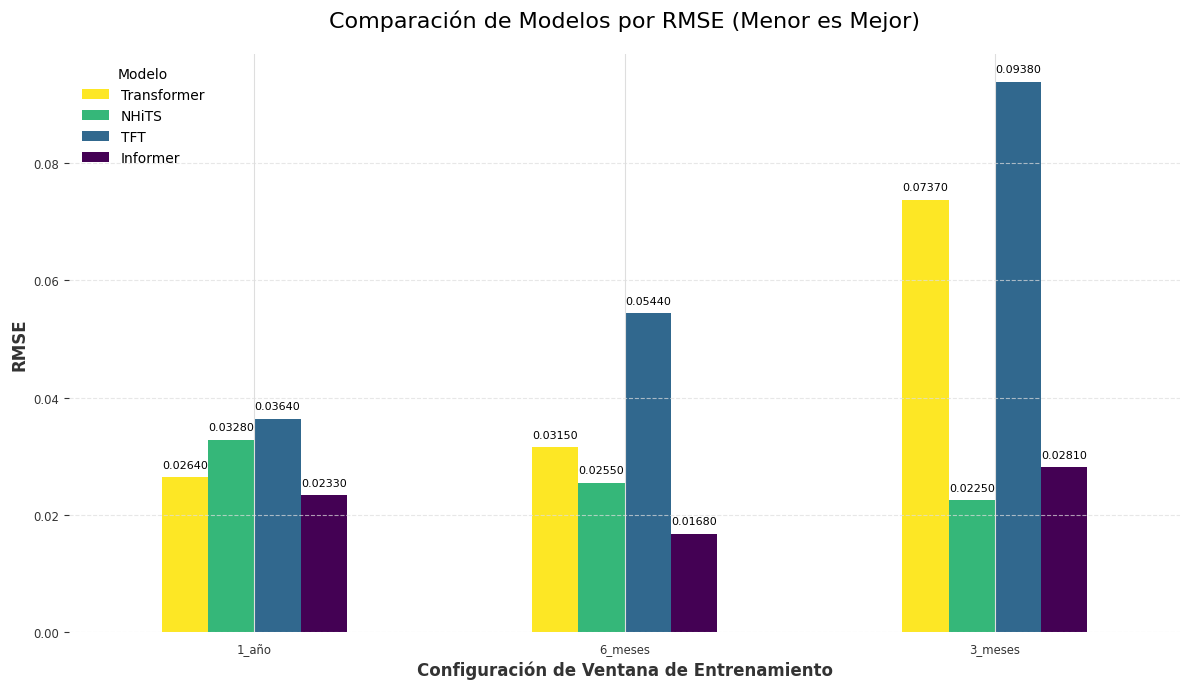


Generando gráfico de barras para Tiempos de Entrenamiento...


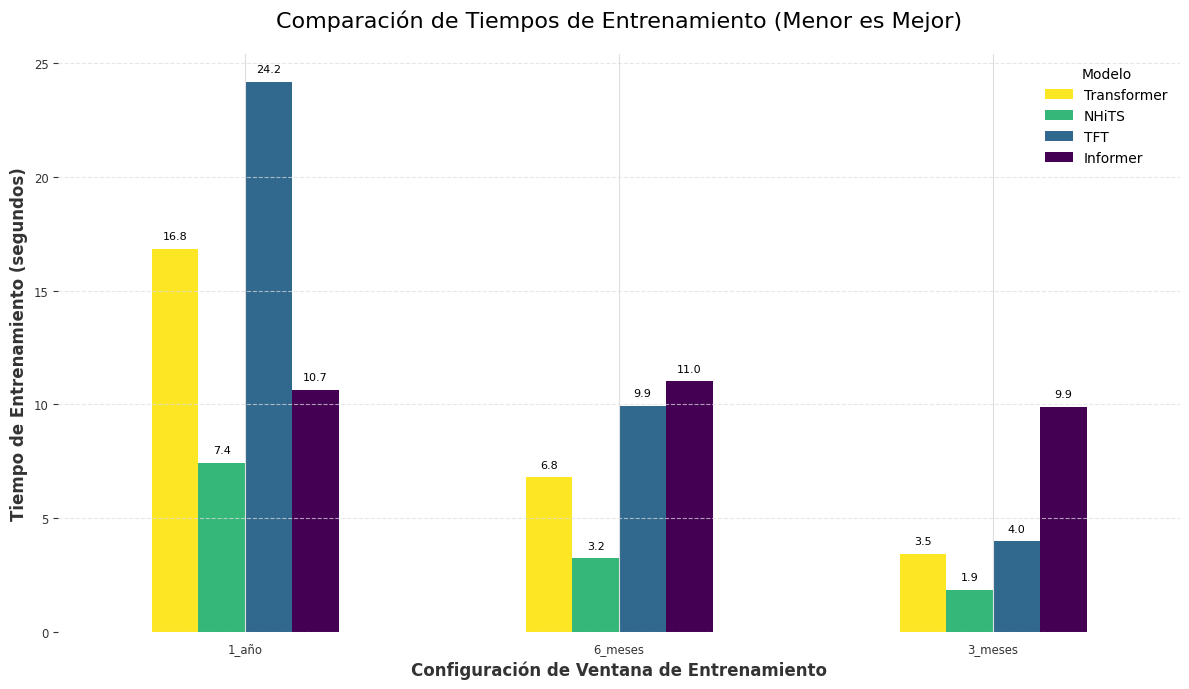


Generando gráfico de barras para Tamaño de Modelos...


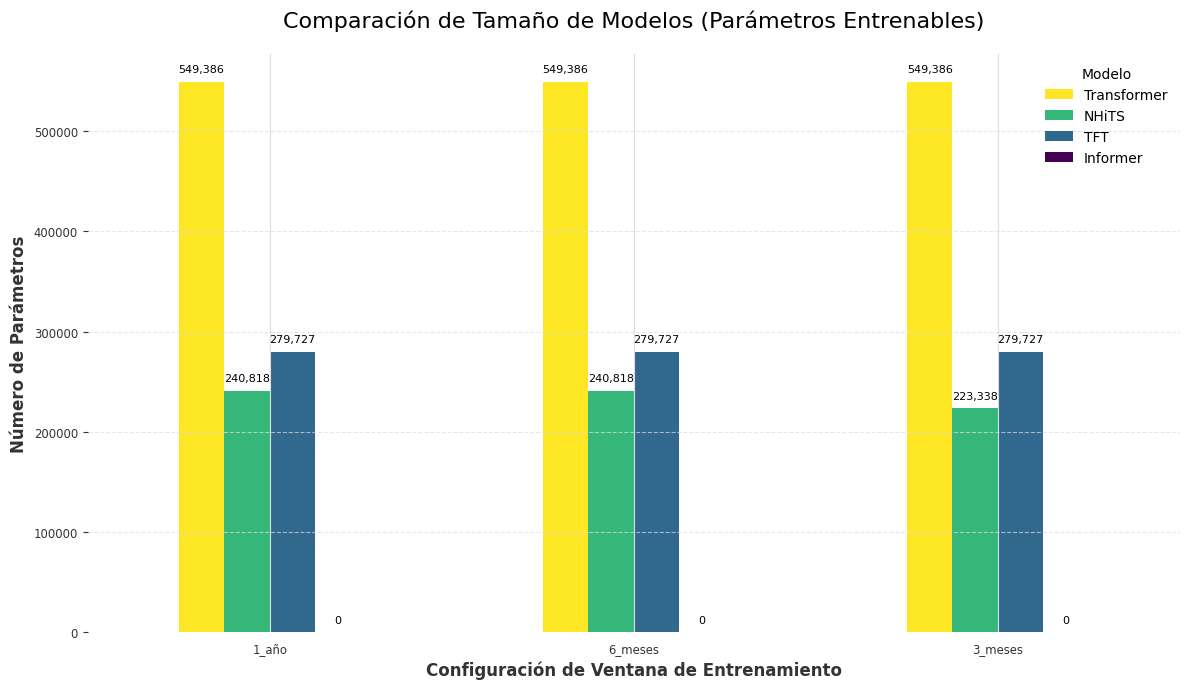

In [6]:
metrics_to_plot = [
    {'name': 'MAE', 'suffix': '', 'format': ".5f", 'lower_is_better': True},
    {'name': 'MAPE', 'suffix': ' (%)', 'format': ".2f", 'lower_is_better': True},
    {'name': 'RMSE', 'suffix': '', 'format': ".5f", 'lower_is_better': True}
]

for metric_info in metrics_to_plot:
    metric_base_name = metric_info['name']
    print(f"Generando gráfico de barras para {metric_base_name}...")
    cols_to_plot = [f'Transformer_{metric_base_name}', f'NHiTS_{metric_base_name}', 
                    f'TFT_{metric_base_name}', f'Informer_{metric_base_name}']
    short_names = ['Transformer', 'NHiTS', 'TFT', 'Informer']
    plot_custom_barchart(results_df,
                         cols_to_plot,
                         short_names,
                         title=f'Comparación de Modelos por {metric_base_name} (Menor es Mejor)',
                         y_label=f'{metric_base_name}{metric_info["suffix"]}',
                         lower_is_better=metric_info['lower_is_better'],
                         value_format=metric_info['format'])

print("\nGenerando gráfico de barras para Tiempos de Entrenamiento...")
time_cols = ['Transformer_TrainTime_s', 'NHiTS_TrainTime_s', 'TFT_TrainTime_s', 'Informer_TrainTime_s']
time_short_names = ['Transformer', 'NHiTS', 'TFT', 'Informer']
plot_custom_barchart(results_df,
                     time_cols,
                     time_short_names,
                     title='Comparación de Tiempos de Entrenamiento (Menor es Mejor)',
                     y_label='Tiempo de Entrenamiento (segundos)',
                     lower_is_better=True,
                     value_format=".1f")

print("\nGenerando gráfico de barras para Tamaño de Modelos...")
param_cols = ['Transformer_Params', 'NHiTS_Params', 'TFT_Params', 'Informer_Params']
param_short_names = ['Transformer', 'NHiTS', 'TFT', 'Informer']
plot_custom_barchart(results_df,
                     param_cols,
                     param_short_names,
                     title='Comparación de Tamaño de Modelos (Parámetros Entrenables)',
                     y_label='Número de Parámetros',
                     lower_is_better=True,
                     value_format=",.0f")